# Обучение CNN модели

In [86]:
import numpy as np
import pandas as pd
import os
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Загрузка данных

In [87]:
train_data_path = "images/train"
test_data_path = "images/test"

train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")

### Извлечение сегментов

Теперь нужно подготовить датасет для обучения модели-регрессора. Сперва извлечём сегменты

In [88]:
models = {"early" : YOLO("seg_models/best_early.pt"),
          "late" : YOLO("seg_models/best_late.pt"),
          "full" : YOLO("seg_models/best_full.pt"),
          "best" : YOLO("seg_models/best.pt")}

def get_segmented_images(models, image_paths, display_image=False, do_segment = True):
    """Извлечение детектированных сегментов"""
    best_res = None
    for model in models.keys():
        model = models[model]
        results = model(image_paths, verbose=False)
        if best_res is None or len(results[0].boxes.xyxy) >= len(best_res[0].boxes.xyxy):
            best_res = results
        # if len(results[0].boxes.xyxy) != 0:
        #     break

    results = best_res

    was_segmented = len(results[0].boxes) > 3

    if len(results[0].boxes.xyxy) == 0 or not do_segment:
        # в случае отсутствия детекций
        return [Image.open(img) for img in image_paths], was_segmented
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        
        # Пропускаем изображения без детекций
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Оставляем сегменты
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            segmented_images.append(segment)
            

    # Отрисовка для демонстрации
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images, was_segmented

### Загрузка серии срезов

In [89]:
def get_images(img_root : str, folder : str, side : str, start : int, end : int) -> list[str]:
    """Получение списка последовательности изображений

    Args:
        img_root (str): корневая папка с изображениями
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        list[str]: список путей до изображений
    """
    images = []
    for i in range(start, end + 1):
        path = os.path.join(
            img_root,
            folder,
            f"{folder}_{side}_{i:03d}.png"
        )
        if os.path.exists(path):
            images.append(path)

    return images

### Компоновка сегментов

In [90]:
def merge_segmented_images(root: str, folder: str, side: str, start: int, end: int, do_segment = True) -> Image:
    """Компоновка сегментов по серии срезов

    Args:
        root (str): корневой путь
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        Image: Итоговое изображение PIL.Image
    """
    images_in_range = get_images(root, folder, side, start, end)
    segmented_images, was_segmented = get_segmented_images(models, images_in_range, do_segment=do_segment)

    total_width = sum(img.width for img in segmented_images)
    max_height = max(img.height for img in segmented_images)
    res = Image.new("RGBA", (total_width, max_height * len(segmented_images)), (0, 0, 0, 0))
    sqr_width = int(np.ceil(np.sqrt(total_width * max_height)))
    x_offset = 0
    y_offset = 0
    actual_width = 0
    for segment in segmented_images:
        if x_offset + segment.width > sqr_width:
            actual_width = max(actual_width, x_offset)
            x_offset = 0
            y_offset += max_height
        res.paste(segment, (x_offset, y_offset))
        x_offset += segment.width
    actual_width = max(actual_width, x_offset)
    actual_height = y_offset + max_height
    res = res.crop((0, 0, actual_width, actual_height))

    return res, was_segmented

## Обучение модели

Предварительно будем трансформировать данные

In [91]:
import lightning as L
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.transforms import v2
from torch import nn

### Датасет

In [92]:
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['ImageSegments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)

        return image

    def __len__(self):
        return len(self.df)

Воспроизводимость результатов

In [93]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(0)

Seed set to 0


In [94]:
train_transform = v2.Compose([
    v2.Resize(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

test_transform = v2.Compose([
    v2.Resize(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

### Регрессор

In [95]:
class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected Regression Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### Тест

In [96]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict

            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)



In [97]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))



In [98]:
def calculate_MAPE(preds, targets):
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    res = []
    for i in range(len(targets)):
        target = targets[i]
        pred = preds[i]
        if abs(target) < 1e-3:
            continue
        res.append((np.abs(pred - target) / target) * 100)
    return np.mean(res)

In [99]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)



### Без сегментации

In [100]:
def generate_regression_dataset(df : pd.DataFrame, output : str, src : str, type : str, do_segment : bool = False):
    paths = []
    was_segmented = []
    widths = []
    for _, row in tqdm(df.iterrows(), total = len(df), desc="Генерация датасета"):
        img, segm = merge_segmented_images(
            root=src,
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"],
            do_segment=do_segment
        )
        img_path = os.path.join(output, f'{row["ID"]}.png')
        img.save(img_path)
        paths.append(img_path)
        was_segmented.append(segm)
        widths.append(img.width)
    df["WasSegmented"] = was_segmented
    df["ImageSegments"] = paths
    df["Width"] = widths
    df.to_csv(f"data/{type}CNN.csv")
    return df

In [101]:
output_root = "merged_images"

output_train = os.path.join(output_root, "train")
output_test = os.path.join(output_root, "test")

os.makedirs(output_train, exist_ok=True)
os.makedirs(output_test, exist_ok=True)

In [102]:
from tqdm import tqdm

In [103]:
if not os.path.exists("data/trainCNN.csv"):
    new_train_df = generate_regression_dataset(train_df, output_train, train_data_path, type = "train", do_segment=False)
    new_train_df["RootVolume"] = new_train_df.groupby("FolderName")["RootVolume"].transform("mean")
else:
    new_train_df = pd.read_csv("data/trainCNN.csv")
    
if not os.path.exists("data/testCNN.csv"):
    new_test_df = generate_regression_dataset(test_df, output_test, test_data_path, type = "test")
else:
    new_test_df = pd.read_csv("data/testCNN.csv")

Генерация датасета: 100%|██████████| 130/130 [00:31<00:00,  4.19it/s]


In [104]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(new_train_df, test_size=0.2)


In [105]:
train_dataset = RootVolumeDataset(train, train_transform)
test_dataset = RootVolumeDataset(test, test_transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


model = RootVolumeRegressor()

if os.path.exists("cnn_models/model_no_seg.ckpt"):
    state_dict = torch.load("cnn_models/model_no_seg.ckpt")['state_dict']
    model.load_state_dict(state_dict)
else:
    trainer = L.Trainer(max_epochs = 20)
    trainer.fit(model, train_dataloader)
    os.makedirs("cnn_models", exist_ok=True)
    trainer.save_checkpoint("cnn_models/model_no_seg.ckpt")

In [106]:
model = RootVolumeRegressor()

# Load state dict
if os.path.exists("cnn_models/model_no_seg.pt"):
    state_dict = torch.load("cnn_models/model_no_seg.pt")['state_dict']
    model.load_state_dict(state_dict)
    model.eval()
    dummy_input = torch.randn(1, 3, 128, 128)
    torch.onnx.export(
        model,
        dummy_input,
        "./cnn_models/model_no_seg.onnx",
        export_params=True,
        opset_version=14,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={
            "input": {0: "batch_size"},
            "output": {0: "batch_size"}
        }
    )

In [107]:
state_dict = torch.load("cnn_models/model_no_seg.pt")['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [108]:
preds, target = get_model_preds(model, test_dataloader)
calculate_rmse(preds, target)

np.float32(1.1007513)

In [109]:
new_test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
preds, target = get_model_preds(model, test_dataloader)
targets=target
preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
res = []
for i in range(len(targets)):
    target = targets[i]
    pred = preds[i]
    if abs(target) < 1e-3:
        res.append(0)
    else:
        res.append((np.abs(pred - target) / target) * 100)


test["Preds"] = preds
test["MAPE"] = res
test.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,WasSegmented,ImageSegments,Width,Preds,MAPE
260,ID_884849_Bmtyoy,Pfp24vx905,3,R,27,34,2.150,TMEB419,Early,False,merged_images/train/ID_884849_Bmtyoy.png,1022,1.950528,9.277787
320,ID_747419_Zihzns,F1p0lhe1ij,4,R,30,37,2.350,IITA-TMS-IBA000070,Early,False,merged_images/train/ID_747419_Zihzns.png,1036,1.819219,22.586443
144,ID_355808_Brk59j,Mrw7chmalv,6,L,18,23,2.100,IBA154810,Early,False,merged_images/train/ID_355808_Brk59j.png,915,2.338398,11.352289
52,ID_211500_Ndgm1d,Vbkivqphuz,5,L,20,32,2.100,TMEB693,Early,False,merged_images/train/ID_211500_Ndgm1d.png,955,2.190696,4.318885
210,ID_321332_Jptlgu,Pw4ytibfql,4,R,28,35,1.325,TMEB419,Early,False,merged_images/train/ID_321332_Jptlgu.png,975,1.978499,49.320667


In [110]:
import seaborn as sns

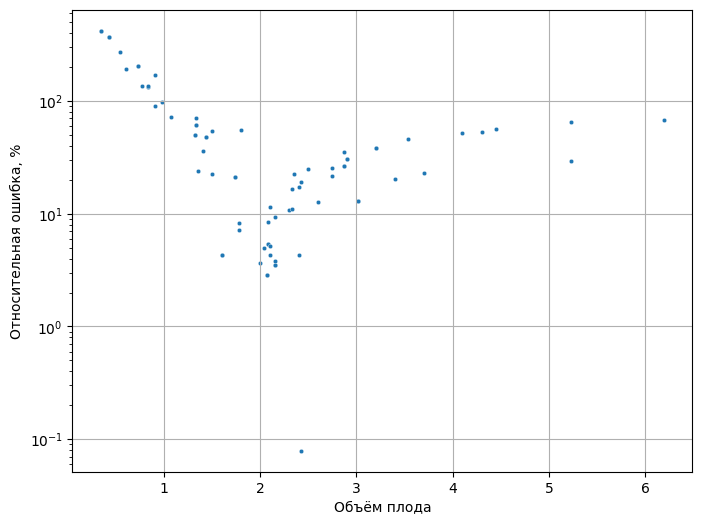

In [111]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=test,
    x='RootVolume',
    y='MAPE',

    # hue='color',
    # palette={'Доп разметка': 'red', 'Без': 'blue'},
    s=10, 
    # legend='full'
)

ax.set_yscale('log')
ax.set_ylabel("Относительная ошибка, %")
ax.set_xlabel("Объём плода")
plt.grid(True)
plt.show()

In [112]:
print(np.round(np.quantile(test["MAPE"], q=0.5), 3))

26.334
